# Imports

In [2]:
from os import walk
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image

from sklearn.model_selection import train_test_split

import numpy as np

%matplotlib inline

# Constants

In [3]:
spam1 = 'SpamData/Processing/spam_assassin_corpus/spam_1'
spam2 = 'SpamData/Processing/spam_assassin_corpus/spam_2'
ham1 = 'SpamData/Processing/spam_assassin_corpus/easy_ham_1'
ham2 = 'SpamData/Processing/spam_assassin_corpus/easy_ham_2'

processed_data = 'SpamData/Processing/email_data.json'
bin_mask = 'SpamData/Processing/wordcloud_resources/bin.png'
ok_mask = 'SpamData/Processing/wordcloud_resources/thumbs-up.png'
size_of_vocabulary = 2500
word_id_data = 'SpamData/Processing/word-by-id.csv'
trainning_data_file  = 'SpamData/Training/train.txt'
testing_data_file  = 'SpamData/Testing/test.txt'

# Data Preprocessing

In [4]:
def body_gen(path):
    """
    This Generator function Helps to return a tuple containing filename,body of email
    """
    for root,dirname,filenames in walk(path):
        for file in filenames:
            req_path = '/'.join([root,file])
            stream = open(req_path, encoding = 'latin-1')
            body1 = []
            ok = False
            for line in stream:
                if ok:
                    body1.append(line)
                elif(line == '\n'):
                    ok = True

            stream.close()

            body = '\n'.join(body1)
            yield file,body

In [5]:
def df_gen(path,classified_as):
    """
    This function is used to call the body_gen generator function and returns a data frame which contains
    mail_body and the classification of mail
    """
    rows = []
    rownames=[]
    for file,body in body_gen(path):
        rows.append({"Mail_body": body,"class":classified_as})
        rownames.append(file)
    return pd.DataFrame(rows,index=rownames)

In [6]:
spam_df = df_gen(spam1,1)
spam_df = spam_df.append(df_gen(spam2,1))
spam_df.head()

,Mail_body,class
00171.08c5c55e9c2b4062344655e9ee32b979,Lowest rates available for term life insurance...,1
00041.f1b3402799046db3c1f143a911dc085d,Dear Sir or Madam:\n\n\n\nPlease reply to \n\n...,1
00211.d976c6049e8448e7c407c124b580e0ba,"<html>\n\n\n\n<head>\n\n<meta http-equiv=3D""Co...",1
00459.e71f7a769d6b09c6d75bfbe8711dbbbe,Help wanted. We are a 14 year old fortune 500...,1
00489.023c1d77de9365cad956a4c9118aee4b,UNCOMMON EXOTIC PLEASURE BOTANICALS!\n\n\n\nFe...,1


In [7]:
ham_df = df_gen(ham1,0)
ham_df = ham_df.append(df_gen(ham2,0))
ham_df.head()

,Mail_body,class
00771.2ce14d08f77127e0720658404cc4ce11,\n\nRead the article. I'm afraid I don't unde...,0
01429.6d9cae984e2f92f32d70594f5cc37c87,http://www.hughes-family.org/bugzilla/show_bug...,0
02375.edeb9041e87f72ee99fa802021017fc2,URL: http://diveintomark.org/archives/2002/10/...,0
01782.278f53b8f65fcd422cb26c5bbe74599d,use Perl Daily Newsletter\n\n\n\nIn this issue...,0
01772.e17237d8112c2741c1b8819ed4cff474,use Perl Daily Headline Mailer\n\n\n\nPerl Por...,0


In [8]:
data = pd.concat([spam_df,ham_df])
data.shape

(5799, 2)

In [9]:
data.head()

,Mail_body,class
00171.08c5c55e9c2b4062344655e9ee32b979,Lowest rates available for term life insurance...,1
00041.f1b3402799046db3c1f143a911dc085d,Dear Sir or Madam:\n\n\n\nPlease reply to \n\n...,1
00211.d976c6049e8448e7c407c124b580e0ba,"<html>\n\n\n\n<head>\n\n<meta http-equiv=3D""Co...",1
00459.e71f7a769d6b09c6d75bfbe8711dbbbe,Help wanted. We are a 14 year old fortune 500...,1
00489.023c1d77de9365cad956a4c9118aee4b,UNCOMMON EXOTIC PLEASURE BOTANICALS!\n\n\n\nFe...,1


In [10]:
data.tail()

,Mail_body,class
00939.d6d2250a7e855513820bd35e36883d5a,"Okay, I'll ammend that to LIVE OLD tree saving...",0
00570.a8f739b7a0c060d178c0f6c01152b6aa,This is a semi-followup on my previous questio...,0
00549.703d3fc9f56814c467616f8aac31d22d,Not sure what you're asking. \n\n Content-...,0
00179.d15992f3e182d401cc37a1b79c251d03,"OK, I guess that sysctl.conf is the best way ...",0
00647.97e77e8264c32c8b05077edc15721ba2,\n\n\n\nformail did the trick. Thanks to those...,0


# Cleaning My Data

In [11]:
#checking for the null values present in email body
data["Mail_body"].isnull().values.any()

False

In [12]:
#Checking for Empty strings
(data["Mail_body"].str.len() == 0).any()

True

In [13]:
#This block tells us the nummber of values wich contain empty string as a string body
(data["Mail_body"].str.len() == 0).sum()

3

In [14]:
# There are three system files which does not contain any body hence we must delete them
data[data["Mail_body"].str.len() == 0]

,Mail_body,class
cmds,,1
cmds,,1
cmds,,0


In [15]:
# deleting unwanted entries from the dataframe
data = data.drop(['cmds'])
(data["Mail_body"].str.len() == 0).sum()

0

In [16]:
data.shape

(5796, 2)

In [17]:
x = range(0,len(data.index))
data['id'] = x
data

,Mail_body,class,id
00171.08c5c55e9c2b4062344655e9ee32b979,Lowest rates available for term life insurance...,1,0
00041.f1b3402799046db3c1f143a911dc085d,Dear Sir or Madam:\n\n\n\nPlease reply to \n\n...,1,1
00211.d976c6049e8448e7c407c124b580e0ba,"<html>\n\n\n\n<head>\n\n<meta http-equiv=3D""Co...",1,2
00459.e71f7a769d6b09c6d75bfbe8711dbbbe,Help wanted. We are a 14 year old fortune 500...,1,3
00489.023c1d77de9365cad956a4c9118aee4b,UNCOMMON EXOTIC PLEASURE BOTANICALS!\n\n\n\nFe...,1,4
...,...,...,...
00939.d6d2250a7e855513820bd35e36883d5a,"Okay, I'll ammend that to LIVE OLD tree saving...",0,5791
00570.a8f739b7a0c060d178c0f6c01152b6aa,This is a semi-followup on my previous questio...,0,5792
00549.703d3fc9f56814c467616f8aac31d22d,Not sure what you're asking. \n\n Content-...,0,5793
00179.d15992f3e182d401cc37a1b79c251d03,"OK, I guess that sysctl.conf is the best way ...",0,5794


In [18]:
data['File_Name'] = data.index
data.set_index('id',inplace = True)
data

,Mail_body,class,File_Name
id,,,
0,Lowest rates available for term life insurance...,1,00171.08c5c55e9c2b4062344655e9ee32b979
1,Dear Sir or Madam:\n\n\n\nPlease reply to \n\n...,1,00041.f1b3402799046db3c1f143a911dc085d
2,"<html>\n\n\n\n<head>\n\n<meta http-equiv=3D""Co...",1,00211.d976c6049e8448e7c407c124b580e0ba
3,Help wanted. We are a 14 year old fortune 500...,1,00459.e71f7a769d6b09c6d75bfbe8711dbbbe
4,UNCOMMON EXOTIC PLEASURE BOTANICALS!\n\n\n\nFe...,1,00489.023c1d77de9365cad956a4c9118aee4b
...,...,...,...
5791,"Okay, I'll ammend that to LIVE OLD tree saving...",0,00939.d6d2250a7e855513820bd35e36883d5a
5792,This is a semi-followup on my previous questio...,0,00570.a8f739b7a0c060d178c0f6c01152b6aa
5793,Not sure what you're asking. \n\n Content-...,0,00549.703d3fc9f56814c467616f8aac31d22d


In [19]:
# saving my data to a file
data.to_json(processed_data)

# Data Visualization

In [20]:
data['class'].value_counts()

0    3900
1    1896
Name: class, dtype: int64

In [21]:
spam_count = data['class'].value_counts()[1]
ham_count = data['class'].value_counts()[0]

In [22]:
spam_count

1896

In [23]:
ham_count

3900

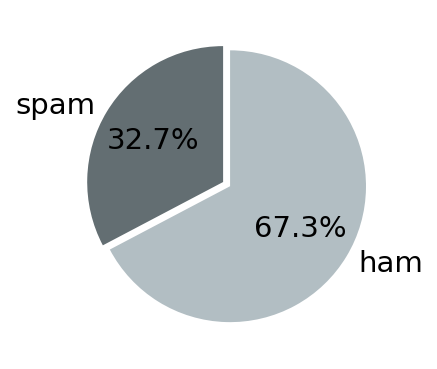

In [24]:
cat_names = ['spam','ham']
plt.figure(figsize=(3,3),dpi=150)
plt.pie([spam_count,ham_count],labels=cat_names,textprops={'fontsize' : 14},
        startangle=90,autopct="%1.1f%%", colors=['#636e72','#b2bec3'],explode=[0.03,0.03])
plt.show()

# Data Preprocessing

### Downloading nltk resources

In [25]:
#downloading word tokenizer
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/sanchit/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [26]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sanchit/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [27]:
# Sample data which includes html
data.at[2,'Mail_body']

'<html>\n\n\n\n<head>\n\n<meta http-equiv=3D"Content-Type"\n\ncontent=3D"text/html; charset=3Diso-8859-1">\n\n<meta name=3D"GENERATOR" content=3D"Microsoft FrontPage 5.0">\n\n<title></title>\n\n</head>\n\n\n\n<body bgcolor=3D"#FFFFFF">\n\n<div align=3D"center"><center>\n\n\n\n<table border=3D"0" cellpadding=3D"5" width=3D"90%">\n\n    <tr>\n\n        <td width=3D"100%"><hr>\n\n        <p align=3D"center"><font color=3D"#FF0000" size=3D"5"\n\n        face=3D"Arial"><strong>EBAY AUCTION NEWS</strong><br>\n\n        </font><font color=3D"#0000FF" face=3D"Arial"><strong>**\n\n        Recommended Resource - Special Edition **</strong><br>\n\n        </font><font face=3D"Arial"><strong>Monday, August 26th, 2002</str=\n\nong></font></p>\n\n        <hr>\n\n        <h3 align=3D"center"><font color=3D"#FF0000" face=3D"Arial">Multip=\n\nle\n\n        Streams of revenue using eBay and Internet: </font></h3>\n\n        <p align=3D"center"><font color=3D"#0000FF" size=3D"4"\n\n        face=3D"Arial"

In [29]:
soup = BeautifulSoup(data.at[2,'Mail_body'],'html.parser')
print(soup.prettify())

<html>
 <head>
  <meta charset="utf-8" content='3D"text/html;' http-equiv='3D"Content-Type"'/>
  <meta 5.0"="" content='3D"Microsoft' frontpage="" name='3D"GENERATOR"'/>
  <title>
  </title>
 </head>
 <body bgcolor='3D"#FFFFFF"'>
  <div align='3D"center"'>
   <center>
    <table border='3D"0"' cellpadding='3D"5"' width='3D"90%"'>
     <tr>
      <td width='3D"100%"'>
       <hr/>
       <p align='3D"center"'>
        <font color='3D"#FF0000"' face='3D"Arial"' size='3D"5"'>
         <strong>
          EBAY AUCTION NEWS
         </strong>
         <br/>
        </font>
        <font color='3D"#0000FF"' face='3D"Arial"'>
         <strong>
          **

        Recommended Resource - Special Edition **
         </strong>
         <br/>
        </font>
        <font face='3D"Arial"'>
         <strong>
          Monday, August 26th, 2002
         </strong>
        </font>
       </p>
      </td>
     </tr>
    </table>
   </center>
  </div>
 </body>
</html>
<hr/>
<h3 align='3D"center"'>
 <fo

In [30]:
soup.get_text()

'\n\n\n\n\n\n\n\n\n\n\nEBAY AUCTION NEWS\n**\n\n        Recommended Resource - Special Edition **\nMonday, August 26th, 2002\n\nMultip=\n\nle\n\n        Streams of revenue using eBay and Internet: \nFREE Auction Profits Toolkit and\n\n        FREE training class\n(For the first 200 respondents)=\n\n\nYou have\n\n        been selected to participate in this FREE offer. \n\n\n        This eBay and Internet e-course, live web training\n\n        conference, and Auction Profit Toolkit could easily sell\n\n        for $297 - but it\'s yours absolutely FREE!\n\n        \n\n\n        This special FREE offer has been brought\n\n        to you by your friends at eBay Auction News. Craig Meyer\n\n        (The Auction Man) has agreed to provide you a free\n\n        "live" training class that you won\'t\n\n        want to miss.\n\n\n        You might say "Craig Meyer - the Auction Man?"\n\n        That\'s because most of you remember Craig as the real estate\n\n        guru who in 1997 helped ove

In [32]:
def process(message,stemmer = PorterStemmer(),stop_words = stopwords.words('english')):
    """
    This function returns the message after Filtering all the stopwords, removing punctuations, lowers
    the strings, stemming the words to the root form and removing the html tags.
    
    Parameters
    ----------
    stemmer : Type of stemmer to be used.
    stop_words : The set of stopwords.
    """
    filtered_words = []
    #Tokenizing and converting to lowercase
    soup = BeautifulSoup(message,'html.parser')
    message = soup.get_text()
    words = word_tokenize(message.lower())
    soup = BeautifulSoup(message,'html.parser')
    for word in words:
        if word not in stop_words:
            if word.isalpha():
                filtered_words.append(stemmer.stem(word))
    return filtered_words

# Applying the process function to each and every mail

In [33]:
converted_messages = data['Mail_body'].apply(process)

/home/sanchit/anaconda3/lib/python3.8/site-packages/bs4/__init__.py:414: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [34]:
doc_ids_spam = data[data['class']==1].index
doc_ids_ham = data[data['class']==0].index

In [35]:
converted_ham = converted_messages[doc_ids_ham]
converted_ham.shape

(3900,)

In [36]:
converted_spam = converted_messages[doc_ids_spam]
converted_spam.shape

(1896,)

In [37]:
flat_ham = [j for i in converted_ham for j in i]
flat_spam = [j for i in converted_spam for j in i]

In [38]:
ham_words = pd.Series(flat_ham).value_counts()
ham_words[:10]

http      7563
use       3633
list      2880
one       2373
get       2286
mail      2255
would     2003
like      1931
messag    1849
work      1800
dtype: int64

In [39]:
spam_words = pd.Series(flat_spam).value_counts()
spam_words[0:10]

http      3097
email     3090
free      2585
click     2058
receiv    1989
list      1971
get       1914
pleas     1852
busi      1792
order     1746
dtype: int64

# Creating Word Cloud for Spam and Ham

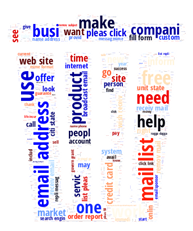

In [40]:
icon = Image.open(bin_mask)
image_mask = Image.new(mode='RGB',size=icon.size,color=(255,255,255))
image_mask.paste(icon,box=icon)
rgb_array = np.array(image_mask)
word_cloud = WordCloud(font_path='SpamData/Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf',mask=rgb_array,background_color='white',min_font_size=1,colormap='flag',max_words=4000).generate(' '.join(flat_spam))
plt.imshow(word_cloud,interpolation="spline16")
plt.axis('off')
plt.rcParams["figure.figsize"] = (8, 16)
plt.show()

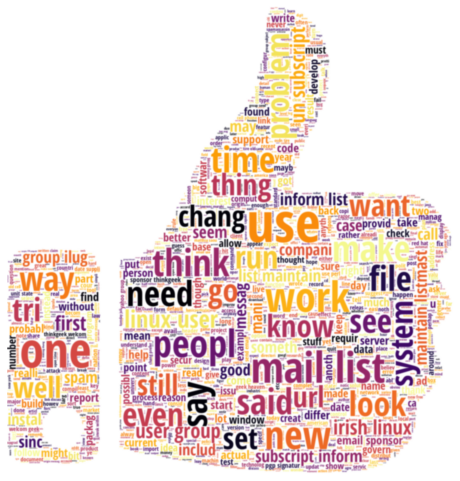

In [41]:
icon = Image.open(ok_mask)
image_mask = Image.new(mode='RGB',size=icon.size,color=(255,255,255))
image_mask.paste(icon,box=icon)
rgb_array = np.array(image_mask)
word_cloud = WordCloud(font_path='SpamData/Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf',mask=rgb_array,background_color='white',colormap='inferno',max_words=2000).generate(' '.join(flat_ham))
plt.imshow(word_cloud,interpolation='bicubic')
plt.axis('off')
plt.rcParams["figure.figsize"] = (5, 10)
plt.show()

In [42]:
stemmed_list = data['Mail_body'].apply(process)

In [43]:
flat_stemmed_list = [j for i in stemmed_list for j in i]

In [44]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print("Unique Words : ",unique_words.shape)
unique_words.head()

Unique Words :  (27334,)


http     10660
use       5019
list      4851
email     4367
get       4200
dtype: int64

In [45]:
frequent_words = unique_words[0:size_of_vocabulary]

In [46]:
frequent_words.head(10)

http     10660
use       5019
list      4851
email     4367
get       4200
mail      3983
one       3907
free      3202
time      3042
work      2883
dtype: int64

In [47]:
word_id = list(range(0,size_of_vocabulary))
vocab = pd.DataFrame({'vocab_words':frequent_words.index.values},index = word_id)
vocab.index.name = 'word_id'
vocab.head()

,vocab_words
word_id,
0,http
1,use
2,list
3,email
4,get


In [48]:
#saving vocab file
vocab.to_csv(path_or_buf=word_id_data,index_label=vocab.index.name,header=vocab.vocab_words.name)

In [49]:
'learn' in set(vocab['vocab_words'])

True

In [50]:
clean_email_lengths = []
for sublist in stemmed_list:
    clean_email_lengths.append(len(sublist))

In [51]:
clean_email_lengths = [len(sublist) for sublist in stemmed_list]
print('Number of words in the longest email:', max(clean_email_lengths))

Number of words in the longest email: 7671


In [52]:
print('Email position in the list (and the data dataframe)', np.argmax(clean_email_lengths))

Email position in the list (and the data dataframe) 4521


# Generating the sparse Matrix

In [53]:
word_list_df = pd.DataFrame.from_records(stemmed_list.tolist())
word_list_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,lowest,rate,avail,term,life,insur,take,moment,fill,onlin,...,None,None,None,None,None,None,None,None,None,None
1,dear,sir,madam,pleas,repli,receiv,china,enterpris,manag,cmc,...,None,None,None,None,None,None,None,None,None,None
2,ebay,auction,news,recommend,resourc,special,edit,monday,august,le,...,None,None,None,None,None,None,None,None,None,None
3,help,want,year,old,fortun,compani,grow,tremend,rate,look,...,None,None,None,None,None,None,None,None,None,None
4,uncommon,exot,pleasur,botan,feel,marvel,sweet,treat,forumul,pleasur,...,None,None,None,None,None,None,None,None,None,None


In [54]:
word_list_df.shape

(5796, 7671)

In [55]:
x_train,x_test,y_train,y_test = train_test_split(word_list_df, data['class'],test_size = 0.3,random_state = 42)

In [56]:
print("Number of Trainning Samples : ",x_train.shape[0])
print("Number of Testing Samples : ",x_test.shape[0])

Number of Trainning Samples :  4057
Number of Testing Samples :  1739


In [57]:
x_train.index.name = x_test.index.name = 'id'
x_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
id,,,,,,,,,,,,,,,,,,,,,
4844,paid,cuteftp,window,box,well,worth,money,despit,free,altern,...,None,None,None,None,None,None,None,None,None,None
4727,http,david,irish,linux,user,group,ilug,http,un,subscript,...,None,None,None,None,None,None,None,None,None,None
5022,use,perl,daili,newslett,issu,damian,conway,speak,london,meet,...,None,None,None,None,None,None,None,None,None,None
3504,url,http,date,img,http,pravda,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3921,rememb,say,necessarili,good,sourc,look,good,site,http,memori,...,None,None,None,None,None,None,None,None,None,None


In [58]:
y_train.head()

id
4844    0
4727    0
5022    0
3504    0
3921    0
Name: class, dtype: int64

In [59]:
word_index = pd.Index(vocab['vocab_words'])

In [60]:
def sparse_matrix_creation(df,index_word,lables):
    """
    Return sparse matrix as a dataframe with doc_id index,index of the word,lable 
    """
    no_rows = df.shape[0]
    no_cols = df.shape[0]
    word_set = set(index_word)
    dict_list = []
    for i in range(no_rows):
        for j in range(no_cols):
            word = df.iat[i,j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = index_word.get_loc(word)
                cate = lables.at[doc_id]
                
                item = {'LABLE': cate,'DOC_ID': doc_id,'OCCURENCE' : 1, 'WORD_ID' : word_id}
                
                dict_list.append(item)
        
    return pd.DataFrame(dict_list)

In [61]:
%%time

sparse_train_df = sparse_matrix_creation(x_train,word_index,y_train)

CPU times: user 1min 22s, sys: 110 ms, total: 1min 22s
Wall time: 1min 22s


In [62]:
sparse_train_df.head()

,LABLE,DOC_ID,OCCURENCE,WORD_ID
0,0,4844,1,569
1,0,4844,1,163
2,0,4844,1,263
3,0,4844,1,86
4,0,4844,1,657


In [64]:
sparse_train_df.tail()

,LABLE,DOC_ID,OCCURENCE,WORD_ID
429453,1,860,1,642
429454,1,860,1,768
429455,1,860,1,1541
429456,1,860,1,768
429457,1,860,1,68


In [1]:
sparse_train_df.shape

NameError: name 'sparse_train_df' is not defined

In [66]:
train_grouped = sparse_train_df.groupby(['DOC_ID','WORD_ID','LABLE']).sum()
train_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABLE           
0      0       1              2
       2       1              1
       18      1              1
       19      1              1
       26      1              2

In [67]:
train_grouped = train_grouped.reset_index()
train_grouped.head()

,DOC_ID,WORD_ID,LABLE,OCCURENCE
0,0,0,1,2
1,0,2,1,1
2,0,18,1,1
3,0,19,1,1
4,0,26,1,2


In [68]:
train_grouped.shape

(260283, 4)

In [69]:
np.savetxt(trainning_data_file,train_grouped,fmt='%d')

In [70]:
%%time

sparse_test_df = sparse_matrix_creation(x_test,word_index,y_test)

CPU times: user 15 s, sys: 27.4 ms, total: 15 s
Wall time: 15 s


In [71]:
test_grouped = sparse_test_df.groupby(['DOC_ID','WORD_ID','LABLE']).sum()
test_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABLE           
8      2       1              3
       3       1              2
       7       1              1
       10      1              1
       15      1              1

In [72]:
test_grouped = test_grouped.reset_index()
test_grouped.head()

,DOC_ID,WORD_ID,LABLE,OCCURENCE
0,8,2,1,3
1,8,3,1,2
2,8,7,1,1
3,8,10,1,1
4,8,15,1,1


In [73]:
np.savetxt(testing_data_file,test_grouped,fmt='%d')

In [74]:
train_grouped

,DOC_ID,WORD_ID,LABLE,OCCURENCE
0,0,0,1,2
1,0,2,1,1
2,0,18,1,1
3,0,19,1,1
4,0,26,1,2
...,...,...,...,...
260278,5795,2107,0,1
260279,5795,2193,0,1
260280,5795,2290,0,2
260281,5795,2426,0,1


In [75]:
train_doc_id = set(train_grouped.DOC_ID)
test_doc_id = set(test_grouped.DOC_ID)

In [76]:
len(test_doc_id)

1725

In [77]:
len(train_doc_id)

4012

In [78]:
set(x_test.index.values) - test_doc_id

{217, 221, 296, 319, 336, 350, 410, 428, 471, 594, 705, 896, 1874, 1879}